# Unit testing demo

### Agenda 

- To unit test Active connection count monitoring system .
- Depends on the availability of AWS
- Units to be tested
    - lambda_handler : counts active connections in an event stream
    - get_seat_count_from_config : get seats for the customer for which we want to update the active connections
    - update_connection_count : updates the connection and calls send_notification_to_sns is seat limit exceeded
    - send_notification_to_sns : send message to an sns topic



### Mocking AWS locally with moto 

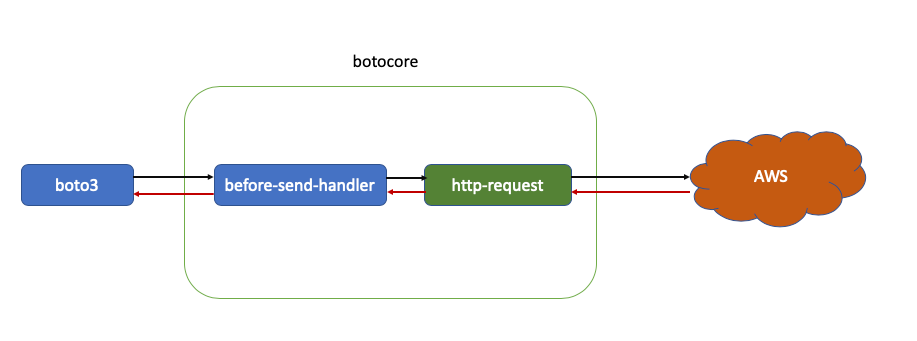

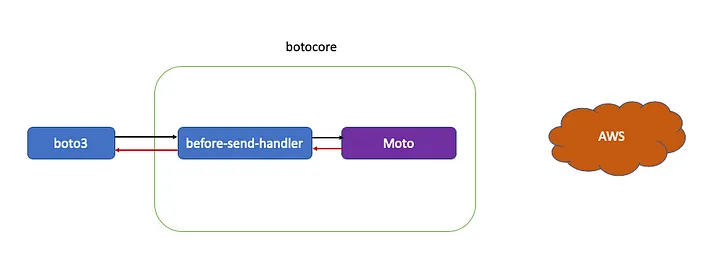

### Imports 

In [12]:
from tabulate import tabulate
from datetime import datetime
from gql import gql
from boto3 import client,resource
from dynamodb_stream_event import DynamoDBDeserializedStreamEvent
from botocore.exceptions import ClientError
from moto import mock_sns , mock_appsync , mock_dynamodb


import os
import json
import ipytest
import pytest
ipytest.autoconfig()

In [13]:
import warnings
warnings.filterwarnings('ignore')

## 1. Set up

In [14]:
@pytest.fixture
def aws_credentials():
    """
    Mocked AWS Credentials for moto.
    """
    os.environ["AWS_ACCESS_KEY_ID"] = "testing"
    os.environ["AWS_SECRET_ACCESS_KEY"] = "testing"
    os.environ["AWS_SECURITY_TOKEN"] = "testing"
    os.environ["AWS_SESSION_TOKEN"] = "testing"

@pytest.fixture
def sns_client(aws_credentials):
    """
    Fixture for generating mocked SNS client for later use.
    """
    with mock_sns():
        conn = client("sns", region_name="us-east-1")
        yield conn

@pytest.fixture
def appsync_client(aws_credentials):
    """
    Fixture for generating mocked AppSync client for later use.
    """
    with mock_appsync():
        conn = client("appsync", region_name="us-east-1")
        yield conn

@pytest.fixture
def ddb_resource(aws_credentials):
    """
    Fixture for generating a mocked DynamoDb resource for later use.
    """
    with mock_dynamodb():
        conn = resource("dynamodb", region_name="us-east-1")
        yield conn

## 2. Excercise

In [15]:
%%ipytest -sv --cov= --cov-report=term-missing
"""
The code includes test cases that verify the functionality of the Lambda function in handling different types of DynamoDB stream events. It covers scenarios for INSERT, REMOVE, and invalid events.

Function to be tested:
- `lambda_handler`:It prints the event, deserializes the events, counts active connections, and returns the counts per customer in the batch.

Test Cases:
- `test_lambda_handler_insert_event`: This test verifies if the Lambda function returns None for an INSERT event. It sets up an INSERT event and checks the response.

- `test_lambda_handler_remove_event`: This test verifies if the Lambda function returns None for a REMOVE event. It sets up a REMOVE event and checks the response.

- `test_lambda_handler_invalid_event`: This test verifies if the Lambda function returns the expected result for an invalid event. It sets up an invalid event (MODIFY) and checks the response.

- `test_lambda_handler_multiple_events`: This test verifies if the Lambda function returns None for multiple events. It sets up multiple events (INSERT and REMOVE) and checks the response.

"""
def test_lambda_handler_insert_event():
    event = {
        "Records": [
            {
                "eventName": "INSERT",
                "dynamodb": {
                    "NewImage": {
                        "CustomerId": {"S": "12345"},
                        "ConfigId": {"S": "config-123"}
                    }
                }
            }
        ]
    }
    context = None

    result = lambda_handler(event, context)
    expected_result={('12345', 'config-123'): 1}
    assert result == expected_result  # Ensure the function returns None for INSERT event

def test_lambda_handler_remove_event():
    event = {
        "Records": [
            {
                "eventName": "REMOVE",
                "dynamodb": {
                    "OldImage": {
                        "CustomerId": {"S": "12345"},
                        "ConfigId": {"S": "config-123"}
                    }
                }
            }
        ]
    }
    context = None

    result = lambda_handler(event, context)
    expected_result={('12345', 'config-123'): -1}
    assert result == expected_result  # Ensure the function returns None for REMOVE event

def test_lambda_handler_invalid_event():
    event = {
        "Records": [
            {
                "eventName": "MODIFY",  # Invalid event name
                "dynamodb": {
                    "newImage": {
                        "CustomerId": {"S": "12345"},
                        "ConfigId": {"S": "config-123"}
                    }
                }
            }
        ]
    }
    context = None

    result = lambda_handler(event, context)
    assert result == "NOT PROCESSING event_type: MODIFY"  # Ensure the function returns the expected result for invalid event

def test_lambda_handler_multiple_events():
    event = {
        "Records": [
            {
                "eventName": "INSERT",
                "dynamodb": {
                    "NewImage": {
                        "CustomerId": {"S": "12345"},
                        "ConfigId": {"S": "config-123"}
                    }
                }
            },
            {
                "eventName": "REMOVE",
                "dynamodb": {
                    "OldImage": {
                        "CustomerId": {"S": "12345"},
                        "ConfigId": {"S": "config-123"}
                    }
                }
            }
        ]
    }
    context = None

    result = lambda_handler(event, context)
    expected_result={('12345', 'config-123'): 0}
    assert result == expected_result  # Ensure the function returns None for multiple events


def lambda_handler(event, context):
    RESPONSE = []

    # deserialize stream events
    deserialized_event = DynamoDBDeserializedStreamEvent(event)

    # create a dictionary to keep count of active connections in the current batch by customerId & configId
    counts = {}

    for record in deserialized_event.records:
        # checking the event object type
        event_type = record["eventName"]

        if event_type == "INSERT":
            # Get the 'CustomerId' , 'ConfigId' from new image
            image = record.dynamodb.new_image
        elif event_type == "REMOVE":
            # Get the 'CustomerId', 'ConfigId' from old image
            image = record.dynamodb.old_image
        else:
            print(f"Invalid event_type: {event_type}")
            return f"NOT PROCESSING event_type: {event_type}"
            
        customer_id = image["CustomerId"]
        config_id = image["ConfigId"]
        
        # Calculate active connection count from records and store in 'counts'
        key = customer_id,config_id
        if key in counts:
            counts[key] += 1 if event_type == 'INSERT' else -1
        else:
            counts[key] = 1 if event_type == 'INSERT' else -1
            
    
    print(f'Active Connection Count per customer in this batch :\n{counts}')
    return counts

======================================= test session starts =======================================
platform win32 -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: C:\Users\RR\Desktop\unit-testing-demo
plugins: anyio-3.5.0, cov-4.1.0
collected 4 items

t_205de0644839499180d3bdd82a48b769.py Active Connection Count per customer in this batch :
{('12345', 'config-123'): 1}
.Active Connection Count per customer in this batch :
{('12345', 'config-123'): -1}
.Invalid event_type: MODIFY
.Active Connection Count per customer in this batch :
{('12345', 'config-123'): 0}
.

---------- coverage: platform win32, python 3.9.12-final-0 -----------
Name                                    Stmts   Miss  Cover   Missing
---------------------------------------------------------------------
dynamodb_stream_event.py                   33     20    39%   10-25, 30, 38-44, 48-49, 54-59, 65-75, 78-79
t_205de0644839499180d3bdd82a48b769.py       0      0   100%
----------------------------------------------

In [16]:
%%ipytest -v --cov=. --cov-report=term-missing
"""
The code includes test cases that verify the functionality of retrieving seat counts by executing a GraphQL query using the AppSync client.

Function to be tested:
- `get_seat_count`

Test Cases:
- `test_get_seat_count_success`: This test verifies if the seat count is correctly retrieved from the AppSync client when a successful response is received. It sets up a mock response with a predefined seat count and checks if the returned seat count matches the expected value.

- `test_get_seat_count_exception`: This test simulates an exception scenario by setting up a mock response containing an error. It checks if the seat count is `None` when an exception occurs during the retrieval process.

Fixtures:
- `appsync_client`: This fixture provides an instance of the AppSync client, which is used in the test cases.
"""

def test_get_seat_count_success(appsync_client):
    # Set up the mock response
    response = {
        "getAgentAssistConfig": {
            "Seats": "10"
        }
    }
    appsync_client.execute = lambda query: response

    # Test case 1: Successful response
    customer_id = "12345"
    config_id = "123"
    seat_count = get_seat_count(appsync_client, customer_id, config_id)
    assert seat_count == 10

def test_get_seat_count_exception(appsync_client):

    # Test case 2: Exception occurred
    response = {
        "errors": [
            {
                "message": "Some error occurred"
            }
        ]
    }
    appsync_client.execute = lambda query: response

    customer_id = "67890"
    config_id = "456"
    seat_count = get_seat_count(appsync_client, customer_id, config_id)
    assert seat_count is None

def get_seat_count(appsync_client,customer_id, config_id):

    query = gql(
        """
            query MyQuery {
        getAgentAssistConfig(ConfigId: "%s", CustomerId: "%s") {
            Seats
            }
         }
        """
        % (config_id, customer_id)
    )

    try:
        # Execute the query
        response = appsync_client.execute(query)
        seat_count = int(response["getAgentAssistConfig"]["Seats"])
        return seat_count

    except Exception as e:
            return

======================================= test session starts =======================================
platform win32 -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: C:\Users\RR\Desktop\unit-testing-demo
plugins: anyio-3.5.0, cov-4.1.0
collected 2 items

t_205de0644839499180d3bdd82a48b769.py ..                                                     [100%]

---------- coverage: platform win32, python 3.9.12-final-0 -----------
Name                                    Stmts   Miss  Cover   Missing
---------------------------------------------------------------------
dynamodb_stream_event.py                   33     33     0%   10-82
t_205de0644839499180d3bdd82a48b769.py       0      0   100%
---------------------------------------------------------------------
TOTAL                                      33     33     0%


======================================== 2 passed in 0.95s ========================================


In [17]:
%%ipytest -sv --cov=. --cov-report=term-missing
"""
The code includes test cases that verify the functionality of sending notifications to SNS when seat limit is exceeded.

Function to be tested:
- `send_notification_to_sns`: Constructs a message to be sent and publishes it to SNS topic and returns a python dictionary having response "status" and "message"

Test Cases:

- `test_send_notification_to_sns_success`: This test sends a successful notification to the SNS topic and checks if the response status code is 200 and the appropriate success message is returned.

- `test_send_notification_to_sns_exception`: This test simulates an exception scenario while sending a notification to SNS and checks if the response status code is not 200 and the expected exception message is returned.


Fixtures:
- `sns_test`: This fixture creates an SNS topic and returns the ARN of the created topic.

"""

@pytest.fixture
def sns_test(sns_client):
    response=sns_client.create_topic(
        Name="test_topic_name"
    )
    yield response['TopicArn']

@pytest.fixture
def args(sns_client,sns_test):
    """Returns a list of arguments to reuse in every test of this module"""

    exceeded_by = 5
    customer_id = "12345"
    config_id = "123"
    seat_count = 10
    yield [sns_client,sns_test,exceeded_by, customer_id, config_id, seat_count]

def test_send_notification_to_sns_success(args):
    # Test case 1: Successful response
    response=send_notification_to_sns(*args)
    customer_id=args[3]

    assert response["status"]==200
    assert response["message"]==f"Message sent to SNS for {customer_id}"
    
def test_send_notification_to_sns_exception(args):
    # Test case 2: Exception occurred

    response=send_notification_to_sns(*args)

    assert response["status"] != 200
    assert response["message"] == f"Exception occured"

def send_notification_to_sns(sns_client,sns_test,exceeded_by, customer_id, config_id,seat_count):
    status = None
    msg = None

    # Get the current date and time in UTC
    utc = datetime.utcnow()

    # Get the date and time separately
    date = utc.strftime("%Y-%m-%d")
    time = utc.strftime("%H:%M:%S")
    
    message = {
        "source": "ActiveConnectionCountMonitor",
        "customer_id": customer_id,
        "config_id": config_id,
        "exceeded_by": exceeded_by,
        "seat_limit":seat_count,
        "date": date,
        "time": time
    }

    # Convert message into JSON
    message_json = json.dumps(message)

    # Publish to SNS topic
    try:
        response = sns_client.publish(
            TopicArn=sns_test,
            Message=message_json,
        )
        # return with appropriate message and status code
        status = response["ResponseMetadata"]["HTTPStatusCode"]
        if status == 200:
            msg = f"Message sent to SNS for {customer_id}"
        else:
            msg = f"Seat limit exceeded by {exceeded_by} for {customer_id} but failed to deliver message to SNS"

        return {"status": status, "message": msg}
    
    except Exception as e:
        print(e)
        return {"status": 500, "message": "Exception occured"}


======================================= test session starts =======================================
platform win32 -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: C:\Users\RR\Desktop\unit-testing-demo
plugins: anyio-3.5.0, cov-4.1.0
collected 2 items

t_205de0644839499180d3bdd82a48b769.py .F

============================================ FAILURES =============================================
_____________________________ test_send_notification_to_sns_exception _____________________________

args = [<botocore.client.SNS object at 0x000002CDACFC6340>, 'arn:aws:sns:us-east-1:123456789012:test_topic_name', 5, '12345', '123', 10]

    def test_send_notification_to_sns_exception(args):
        # Test case 2: Exception occurred
    
        response=send_notification_to_sns(*args)
    
>       assert response["status"] != 200
E       assert 200 != 200

C:\Users\RR\AppData\Local\Temp\ipykernel_11352\2362271734.py:49: AssertionError

---------- coverage: platform win32, python 3.9.12-final

In [21]:
%%ipytest -sv --cov=. --cov-report=json
"""
Function to be tested:
- `update_active_connection`

Test Cases:
- `test_table_creation`: This test verifies if the DynamoDB table is created successfully by checking its status.

- `test_view_records` : To view all the records in the mocked ddb table. 

- `test_update_active_connection_success`: This test verifies if the active connections are updated successfully in the DynamoDB table and the seat limit is not exceeded. It sets up a mock table, SNS client, and test data and checks the response status and message.

- `test_test_update_first_connection_success`: To test if the first record will insert successfully for a customer.

- `test_update_active_connection_seat_exceeded`: This test verifies if the active connections are updated successfully in the DynamoDB table and the seat limit is exceeded. It sets up a mock table, SNS client, and test data and checks the response status and message.

Fixtures:
- `table`: This fixture creates a mock DynamoDB table for testing. It creates a table using the provided table name and returns the table resource.
"""
table_name = "test_connection_summary"

@pytest.fixture
def table(ddb_resource):
        ddb_resource.create_table(
            TableName=table_name,
            KeySchema=[
                {"AttributeName": "CustomerId", "KeyType": "HASH"},
                {"AttributeName": "ConfigId", "KeyType": "RANGE"},
            ],
            AttributeDefinitions=[
                {"AttributeName": "CustomerId", "AttributeType": "S"},
                {"AttributeName": "ConfigId", "AttributeType": "S"},
            ],
            ProvisionedThroughput={"ReadCapacityUnits": 5, "WriteCapacityUnits": 5},
        )
        customer_id = "12345"
        config_id = "config-123"
        count = 3

        ddb_resource.Table(table_name).put_item(
            Item={
                "CustomerId": customer_id,
                "ConfigId": config_id,
                "ActiveConnectionCount": count
            }
        )
    
        # Return the mocked table resource
        yield ddb_resource.Table(table_name)

def test_table_creation(table):
    # Check if the table exists
    assert table.table_status == "ACTIVE" 

def test_view_records(table):
    # Scan the table to retrieve all records
    response = table.scan()

    # Get the list of items from the response
    items = response["Items"]
    table_data = []
    headers = ["Customer ID", "Config ID", "Active Connections"]

    for item in items:
        customer_id = item["CustomerId"]
        config_id = item["ConfigId"]
        active_connections = item["ActiveConnectionCount"]

        row = [customer_id, config_id, active_connections]
        table_data.append(row)

    # Print the records in a table format
    table_str=tabulate(table_data, headers=headers, tablefmt="grid")
    print(table_str)

    # Check the count of retrieved records
    assert len(items) > 0


def test_update_active_connection_success(table,sns_client,sns_test):
    # Test case 1: Successful update
    customer_id = "12345"
    config_id = "config-123"
    seat_count = 10
    count = 2

    result = update_active_connection(sns_client,sns_test,table, count, customer_id, config_id, seat_count)
    test_view_records(table)
    assert result["status"] == 200
    assert result["message"] == f"Update at 'AgentAssistConnectionSummary' table for {customer_id} didn't exceed the seat limit"

def test_update_first_connection_success(table,sns_client,sns_test):
    # Test case 2: Successful insertion of first connection
    customer_id = "8888"
    config_id = "config-88"
    seat_count = 10
    count = 1

    result = update_active_connection(sns_client,sns_test,table, count, customer_id, config_id, seat_count)
    test_view_records(table)
    assert result["status"] == 200
    assert result["message"] == f"Update at 'AgentAssistConnectionSummary' table for {customer_id} didn't exceed the seat limit"

def test_update_active_connection_seat_exceeded(table,sns_client,sns_test):
    # Test case 3: Seat limit exceeded
    customer_id = "12345"
    config_id = "config-123"
    seat_count = 10
    count = 12

    result = update_active_connection(sns_client,sns_test,table, count, customer_id, config_id, seat_count)
    test_view_records(table)
    assert result["status"]==200
    assert result["message"] == f"Message sent to SNS for {customer_id}"

def update_active_connection(sns_client,sns_test,table,count, customer_id, config_id, seat_count):

    status = None
    msg = None
    key = {"CustomerId": customer_id, "ConfigId": config_id}
    update_expression = 'SET #count = if_not_exists(#count, :zero) + :val'

    try:
        # Update active connections at 'AgentAssistConnectionSummary' table
        response = table.update_item(
            Key=key,
            UpdateExpression=update_expression,
            ExpressionAttributeNames={"#count": "ActiveConnectionCount"},
            ExpressionAttributeValues={":val": count , ":zero": 0},
            ReturnValues="UPDATED_NEW",
        )

        status = response["ResponseMetadata"]["HTTPStatusCode"]

        if status == 500:
            return {
                "status": status,
                "message": "Update failed at 'AgentAssistConnectionSummary' table",
            }

        # check if seat limit exceeded after successfull update
        active_connections = response["Attributes"]["ActiveConnectionCount"]
        print(f'Updated Active connections : {active_connections}')
        if active_connections > seat_count:
            exceeded_by = str(active_connections - seat_count)
            return send_notification_to_sns(sns_client,sns_test,exceeded_by, customer_id, config_id , seat_count)

        return {
            "status": status,
            "message": f"Update at 'AgentAssistConnectionSummary' table for {customer_id} didn't exceed the seat limit",
        }

    except ClientError as e:
        error_code=e.response['Error']['Code']
        return {"status": 500, "message": "update failed"}



======================================= test session starts =======================================
platform win32 -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: C:\Users\RR\Desktop\unit-testing-demo
plugins: anyio-3.5.0, cov-4.1.0
collected 5 items

t_205de0644839499180d3bdd82a48b769.py .+---------------+-------------+----------------------+
|   Customer ID | Config ID   |   Active Connections |
+===============+=============+======================+
|         12345 | config-123  |                    3 |
+---------------+-------------+----------------------+
.Updated Active connections : 5
+---------------+-------------+----------------------+
|   Customer ID | Config ID   |   Active Connections |
+===============+=============+======================+
|         12345 | config-123  |                    5 |
+---------------+-------------+----------------------+
.Updated Active connections : 1
+---------------+-------------+----------------------+
|   Customer ID | Config ID   |   

## Services that are not/partially supported by moto 

- IAM : partially supported
- cloudformation: partially
- step function : not supported